In [125]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [129]:
import pandas
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
#read the file and prepare the data
url='https://raw.githubusercontent.com/xjsh1997/STAT6289/main/data_multi_final.csv'
dataset = pandas.read_csv(url,header=0, index_col=0)
dataset.drop('Pulse_daily', axis=1, inplace=True)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())
print(dataset.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.461539   0.541176    0.62963  0.483517
2   0.483517   0.470588    0.62963  0.285714
3   0.285714   0.517647    0.62963  0.263736
4   0.263736   0.400000    0.62963  0.241758
5   0.241758   0.400000    0.62963  0.384615
           SBP_daily  DBP_daily  Temperature
Date                                        
2016/11/1      137.0       76.0         24.5
2016/11/2      139.0       73.0         24.5
2016/11/4      121.0       75.0         24.5
2016/11/8      119.0       70.0         24.5
2016/11/9      117.0       70.0         24.5


In [128]:
# split into train and test sets
values = reframed.values
train = values[:int(len(values)*0.75), :]
test = values[int(len(values)*0.75):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(493, 1, 3) (493,) (165, 1, 3) (165,)


In [116]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
#fit the model
history = model.fit(train_X, train_y, epochs=60, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# Training Phase
model.summary()

Epoch 1/60
5/5 [==============================] - 3s 133ms/step - loss: 0.3238 - val_loss: 0.2383
Epoch 2/60
5/5 [==============================] - 0s 12ms/step - loss: 0.2778 - val_loss: 0.1933
Epoch 3/60
5/5 [==============================] - 0s 12ms/step - loss: 0.2341 - val_loss: 0.1543
Epoch 4/60
5/5 [==============================] - 0s 12ms/step - loss: 0.1942 - val_loss: 0.1256
Epoch 5/60
5/5 [==============================] - 0s 12ms/step - loss: 0.1603 - val_loss: 0.1133
Epoch 6/60
5/5 [==============================] - 0s 11ms/step - loss: 0.1379 - val_loss: 0.1148
Epoch 7/60
5/5 [==============================] - 0s 11ms/step - loss: 0.1275 - val_loss: 0.1210
Epoch 8/60
5/5 [==============================] - 0s 13ms/step - loss: 0.1249 - val_loss: 0.1274
Epoch 9/60
5/5 [==============================] - 0s 13ms/step - loss: 0.1248 - val_loss: 0.1306
Epoch 10/60
5/5 [==============================] - 0s 12ms/step - loss: 0.1244 - val_loss: 0.1302
Epoch 11/60
5/5 [===========

In [106]:
import datetime

start = datetime.datetime.strptime("01-11-2016", "%d-%m-%Y")
end = datetime.datetime.strptime("21-01-2020", "%d-%m-%Y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]


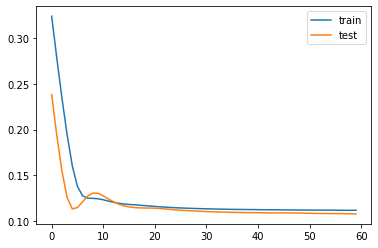

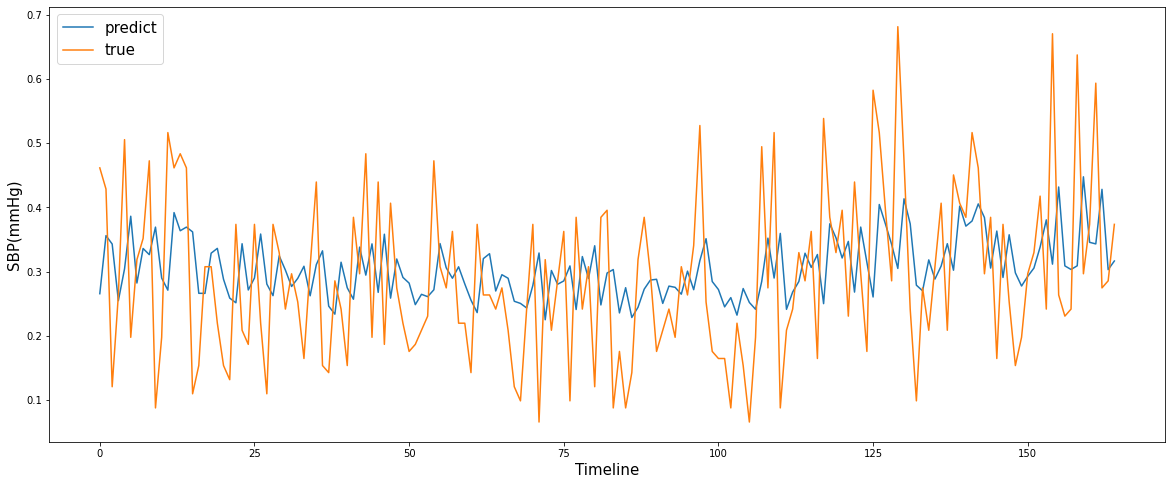

In [117]:
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


#
yhat = model.predict(test_X)
SBP_prediction = yhat.reshape((-1))
# ---> Special function: convert <datetime.date> to <Timestamp>
#def datetime_to_timestamp(x):
    #'''
        #x : a given datetime value (datetime.date)
    #'''
    #return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


#y_pred_future = sc_predict.inverse_transform(predictions_future)
#y_pred_train = sc_predict.inverse_transform(predictions_train)

#PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
#PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

## Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
#PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

#PREDICTION_TRAIN.head(3)




from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(test_y[:500], label='true')
pyplot.legend()

pyplot.ylabel('SBP(mmHg)', size=15)
pyplot.xlabel('Timeline', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

In [118]:
import plotly.express as px
import plotly.graph_objs as go

In [119]:
print(train_y.shape)

(493,)


In [120]:
SBP_prediction = SBP_prediction.reshape(-1, 3)
SBP_prediction = scaler.inverse_transform(SBP_prediction)


test_y = test_y.reshape(-1, 3)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:, 0]
SBP_prediction = SBP_prediction[:, 0]

In [121]:
trace2 = go.Scatter(
    x = date_generated,
    y = SBP_prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_generated,
    y = test_y,
    mode='lines',
    name = 'Ground Truth'
)

fig = go.Figure(data=[trace2, trace3])
fig.show()

In [124]:
mse = mean_squared_error(test_y, SBP_prediction)

rmse = sqrt(mean_squared_error(test_y, SBP_prediction))

print(mse, rmse)

146.92538 12.12127817193733
